<a href="https://colab.research.google.com/github/solobala/CVML10/blob/main/CVML10_DZ1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание «Сегментация и детекция объектов»

Преподаватель: Наталья Баданина, Юлия Пономарева, Артём Качалкин
Распознавание рукописного ввода на примере базы MNIST

Построить классификатор изображений рукописного ввода на базе MNIST. В качестве шаблона в данной работе можно использовать ipython-ноутбук 002-digit.ipynb.

Классификатор предлагается строить на признаках, полученных в результате предобработки изображений, например, гистограммы градиентов (HOG) или результат PCA преобразования.

В качестве модели классификатора можно использовать любую известную Вам модель, за исключением сверточных нейронных сетей.

Критерием качества классификатора является метрика accuracy. Для получения зачета по данной работе, значение метрики accuracy должно быть больше 0.6. Метрика оценивается на тестовой выборке в рамках контеста [Digit Recognizer](https://www.kaggle.com/c/digit-recognizer) на Kaggle.

Решение необходимо предоставить в виде ipython-ноутбука с реализацией процесса построения модели и скриншота с финальным результатом на Kaggle.

Для получения метрики с Kaggle необходимо сохранить выполненные предсказания в файл csv (пример файла с записанными предсказаниями находится во вкладке Data на странице с заданием на Kaggle).
Затем зайти на страницу с заданием на Kaggle (вход в личный кабинет должен быть уже осуществлён). Нажать на кнопку Submit Predictions.
В открывшемся окне загрузить файл с предсказанными значениями. Нажать на кнопку Make Submission.
В открывшемся окне будет указан Score.
Обратите внимание, что количество загруженных предсказаний в день может быть ограничено.Не забудьте ответы в файле проверки перевести в целочисленный вид, иначе score будет равен 0.0

## 1. Импорт библиотек

In [1]:
import cv2
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

## 2. Пользовательские функции

In [2]:
def make_dataset(train_url: str, test_url: str) -> tuple[
    np.ndarray, np.ndarray, np.ndarray, np.ndarray] :
  """Загрузка датасета из гитхаба, сохранение разметки"""
  train = np.loadtxt(train_url, delimiter=',', skiprows=1)
  test = np.loadtxt(test_url, delimiter=',', skiprows=1)
  train_label = train[:, 0] # сохраняем разметку в отдельную переменную
  train_img = np.reshape(train[:, 1:], (len(train[:, 1:]), 28, 28)) # приводим размерность к удобному для обаботки виду
  test_img = np.resize(test, (test.shape[0], 28, 28))
  test_label = test[:, 0] # сохраняем разметку в отдельную переменную
  return train_img, train_label, test_img, test_label

In [3]:
def deskew(img):
    """ Функция позволяет уменьшить наклон в рукописных цифрах"""
    m = cv2.moments(img)
    SZ = 28 # Size of the image
    if abs(m['mu02']) < 1e-2:
        return img.copy()
    skew = m['mu11']/m['mu02']
    M = np.float32([[1, skew, -0.5*SZ*skew], [0, 1, 0]])
    img = cv2.warpAffine(img, M, (SZ, SZ), flags=cv2.WARP_INVERSE_MAP | cv2.INTER_LINEAR)
    return img

In [4]:
def view_data(images: np.ndarray, labels: np.ndarray, func=None) -> None:
  """Визуализация данных"""
  %matplotlib inline
  from matplotlib import pyplot as plt
  fig = plt.figure(figsize=(20, 10))
  for i, img in enumerate(images[0:5], 1):
      subplot = fig.add_subplot(1, 7, i)
      if func == 'deskew':
        plt.imshow(deskew(img), cmap='gray');
        subplot.set_title('De-Skewed Image %s' % labels[i - 1]);
      else:
        plt.imshow(img, cmap='gray')
        subplot.set_title('%s' % labels[i - 1])


In [5]:
def build_features(stage: str, images, labels, func=None, draw=None) -> np.ndarray:
  """ Вычисляет дескрипторы для элементов массивы img"""
  # 0. Предобработка images с пjмощью deskew
  if func == 'deskew':
    for i in range(len(images)):
      images[i] = deskew(images[i])
  # 1. Вычисляем X и Y составляющие градиента для элементов images с помощью оператора Собеля
  sobel_x = np.zeros_like(images)
  sobel_y = np.zeros_like(images)

  for i in range(len(images)):
      sobel_x[i] = cv2.Sobel(images[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
      sobel_y[i] = cv2.Sobel(images[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

  # 2. Вычисляем угол и длину вектора градиента для элементов images
  g, theta = cv2.cartToPolar(sobel_x, sobel_y)

  # 2.1. Визуализация по запросу
  if draw:
    fig = plt.figure(figsize=(20, 10))
    for i, img in enumerate(g[:5], 1):
        subplot = fig.add_subplot(1, 7, i)
        plt.imshow(img, cmap='gray');
        subplot.set_title('%s' % labels[i - 1]);
        subplot = fig.add_subplot(3, 7, i)
        plt.hist(theta[i - 1].flatten(),
                bins=16, weights=g[i - 1].flatten())

  # 3. Вычисляем гистограммы градиентов
  hist = np.zeros((len(images), 16))

  for i in range(len(images)):
      hist_, borders = np.histogram(theta[i],
                                  bins=16,
                                  range=(0., 2. * np.pi),
                                  weights=g[i])
      hist[i] = hist_
  # 4. Нормируем вектор гистограммы для элементов обучающей выборки
  if stage == 'train':
    hist = hist / np.linalg.norm(hist, axis=1)[:, None]

  # 5. Задаем параметры для вычисления дескриптора
  winSize = (28,28)
  blockSize = (14,14)
  blockStride = (14,14)
  cellSize = (7,7)
  nbins = 9
  derivAperture = 1
  winSigma = 4.
  histogramNormType = 0
  L2HysThreshold = 2.0000000000000001e-01
  gammaCorrection = 0
  nlevels = 64

  # 6. Создаем объект HOGDescriptor с заданным параметрами
  hog = cv2.HOGDescriptor(winSize,
                          blockSize,
                          blockStride,
                          cellSize,
                          nbins,
                          derivAperture,
                          winSigma,
                          histogramNormType,
                          L2HysThreshold,
                          gammaCorrection,
                          nlevels)

  # 7. Вычисляем все дескрипторы
  descriptors = np.zeros((len(images), 144))
  for i in range(len(images)):
      descriptors[i] = hog.compute(np.uint8(images[i])).reshape(-1)
  # 8. визуализация по запросу
  if draw:
    fig = plt.figure(figsize=(20, 10))
    for i, img in enumerate(g[:5], 1):
      subplot = fig.add_subplot(1, 7, i)
      plt.imshow(img, cmap='gray');
      subplot.set_title('%s' % labels[i - 1]);
      subplot = fig.add_subplot(3, 7, i)
      plt.hist(descriptors[i-1].flatten())

  return descriptors

In [7]:
def train_model(train_label, train_descriptor, clf) -> tuple:
  """Разделение датасета на train и val"""
  y_train, y_val, x_train, x_val = train_test_split(
      train_label, train_descriptor, test_size=0.2,
      random_state=42)
  # Train classifier on the HOG descriptor
  classifier = clf
  classifier.fit(x_train, y_train)
  # Test the classifier on the test set of digits
  y_predict = classifier.predict(x_val)
  accuracy = accuracy_score(y_val, y_predict)
  return accuracy, classifier

## 3. Загрузка данных

In [8]:
train_url = 'https://raw.githubusercontent.com/a4tunado/lectures/master/002/data/digit/train.csv'
test_url = 'https://raw.githubusercontent.com/a4tunado/lectures/master/002/data/digit/test.csv'
train_img, train_label, test_img, test_label =  make_dataset(train_url, test_url)

### 3.1. Визуализация данных

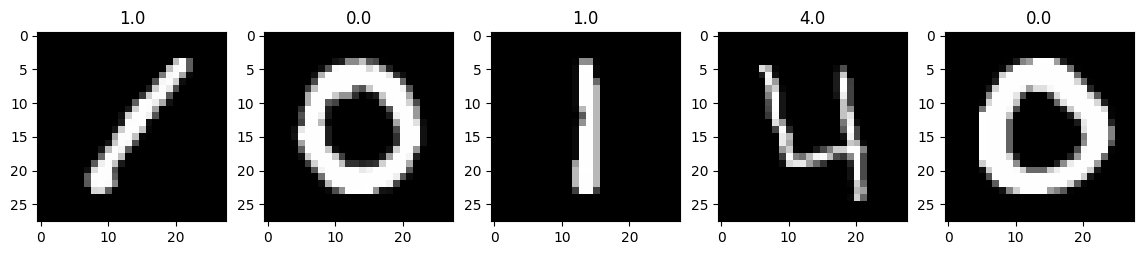

In [9]:
view_data(train_img, train_label)

## 4. Преобразование данных

Классификатор предполагается строить на признаках, полученных в результате предобработки изображений и получения гистограммы градиентов (HOG)
1. Вычисляем X и Y составляющие градиента для элементов images с помощью оператора Собеля
2. Вычисляем угол и длину вектора градиента для элементов images (Визуализация по запросу draw=True)
3. Вычисляем гистограммы градиентов
4. Нормируем вектор гистограммы для элементов обучающей выборки
5. Задаем параметры для вычисления дескриптора
6. Создаем объект HOGDescriptor с заданным параметрами
7. Вычисляем все дескрипторы (Визуализация по запросу draw=True)


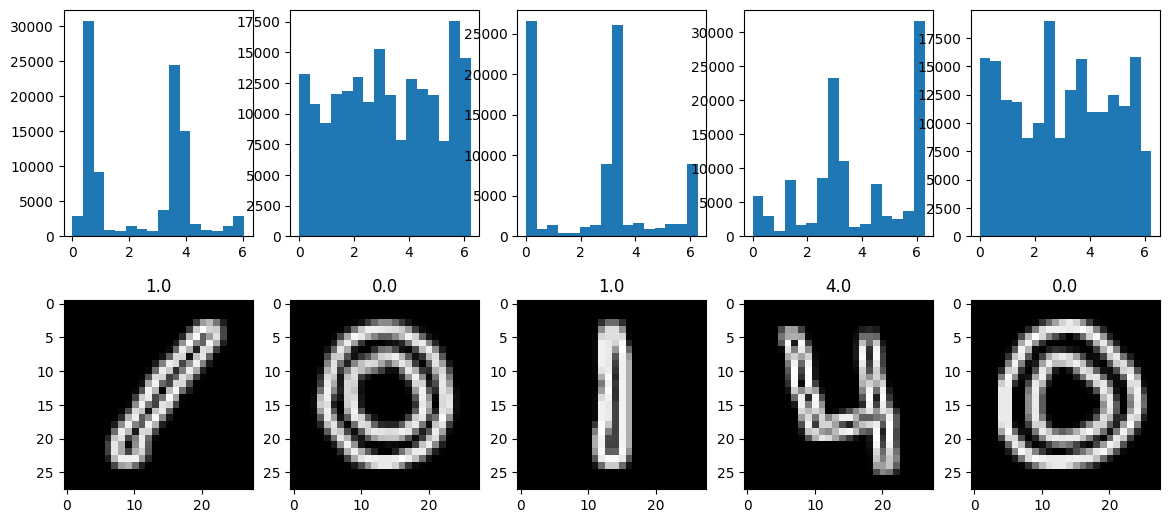

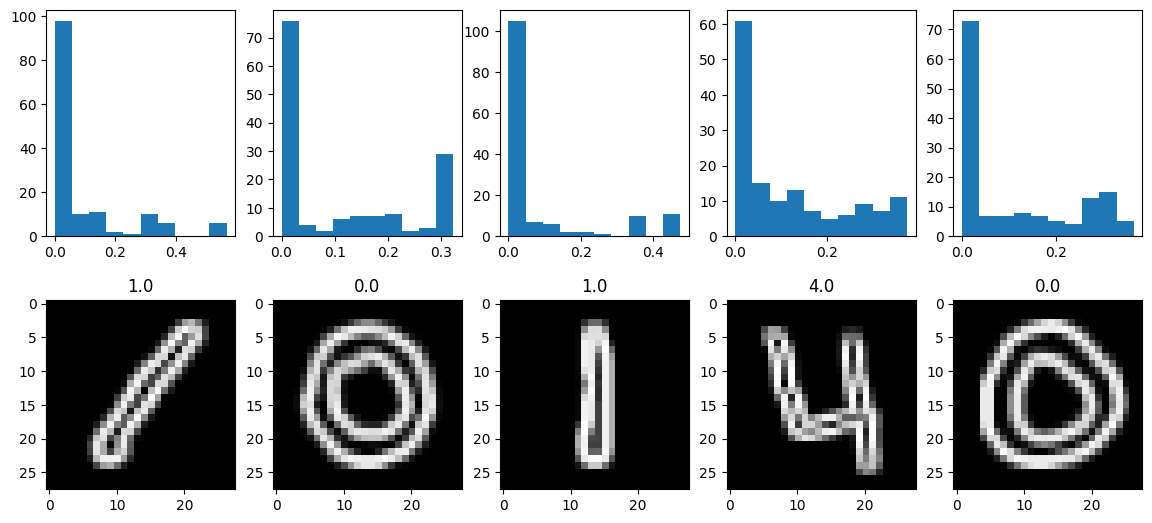

In [10]:
train_descriptor = build_features('train', train_img, train_label, func=None, draw=True)

In [11]:
test_descriptor = build_features(None, test_img, None, None, draw=False)

## 5. Моделирование

In [12]:
models = dict()
results = []
models['SVC'] = SVC(kernel='linear', C=1.0, random_state=42)
models['RF'] = RandomForestClassifier(random_state=42)
models['DTC'] = DecisionTreeClassifier(random_state=42)
models['BC'] = BaggingClassifier(random_state=42)
best_accuracy = 0.6
for key, value in models.items():
  accuracy, classifier = train_model(train_label, train_descriptor, value)
  if accuracy > best_accuracy:
    best_accuracy = accuracy
    best_clf = classifier
  results.append({"model": key, "accuracy": accuracy })
print(results)

[{'model': 'SVC', 'accuracy': 0.974047619047619}, {'model': 'RF', 'accuracy': 0.9682142857142857}, {'model': 'DTC', 'accuracy': 0.8696428571428572}, {'model': 'BC', 'accuracy': 0.9292857142857143}]


Лучшие результаты  в SVC

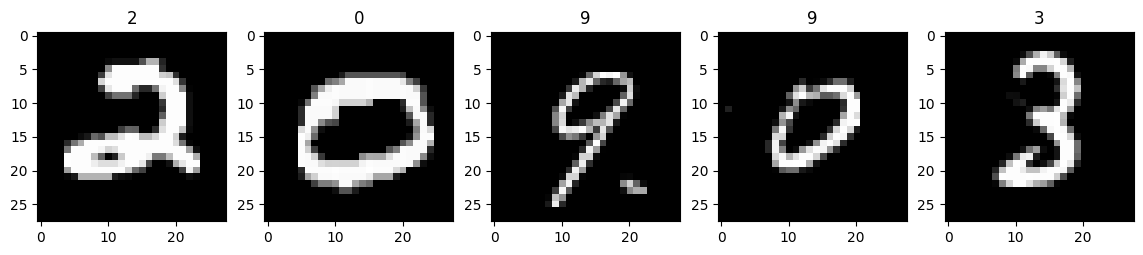

In [13]:
y_predict_test = best_clf.predict(test_descriptor)
y_predict_test = y_predict_test.astype(np.uint8)
view_data(test_img, y_predict_test)

In [14]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(y_predict_test, 1):
        dst.write('%s,%s\n' % (i, p))

In [15]:
!head submit.txt

ImageId,Label
1,2
2,0
3,9
4,9
5,3
6,7
7,0
8,3
9,0


In [16]:
df=pd.read_csv('submit.txt', sep=',')

df['Label'] = df['Label'].apply(lambda x: int(x))
df.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


In [17]:
df.to_csv('submit.csv', index=False)

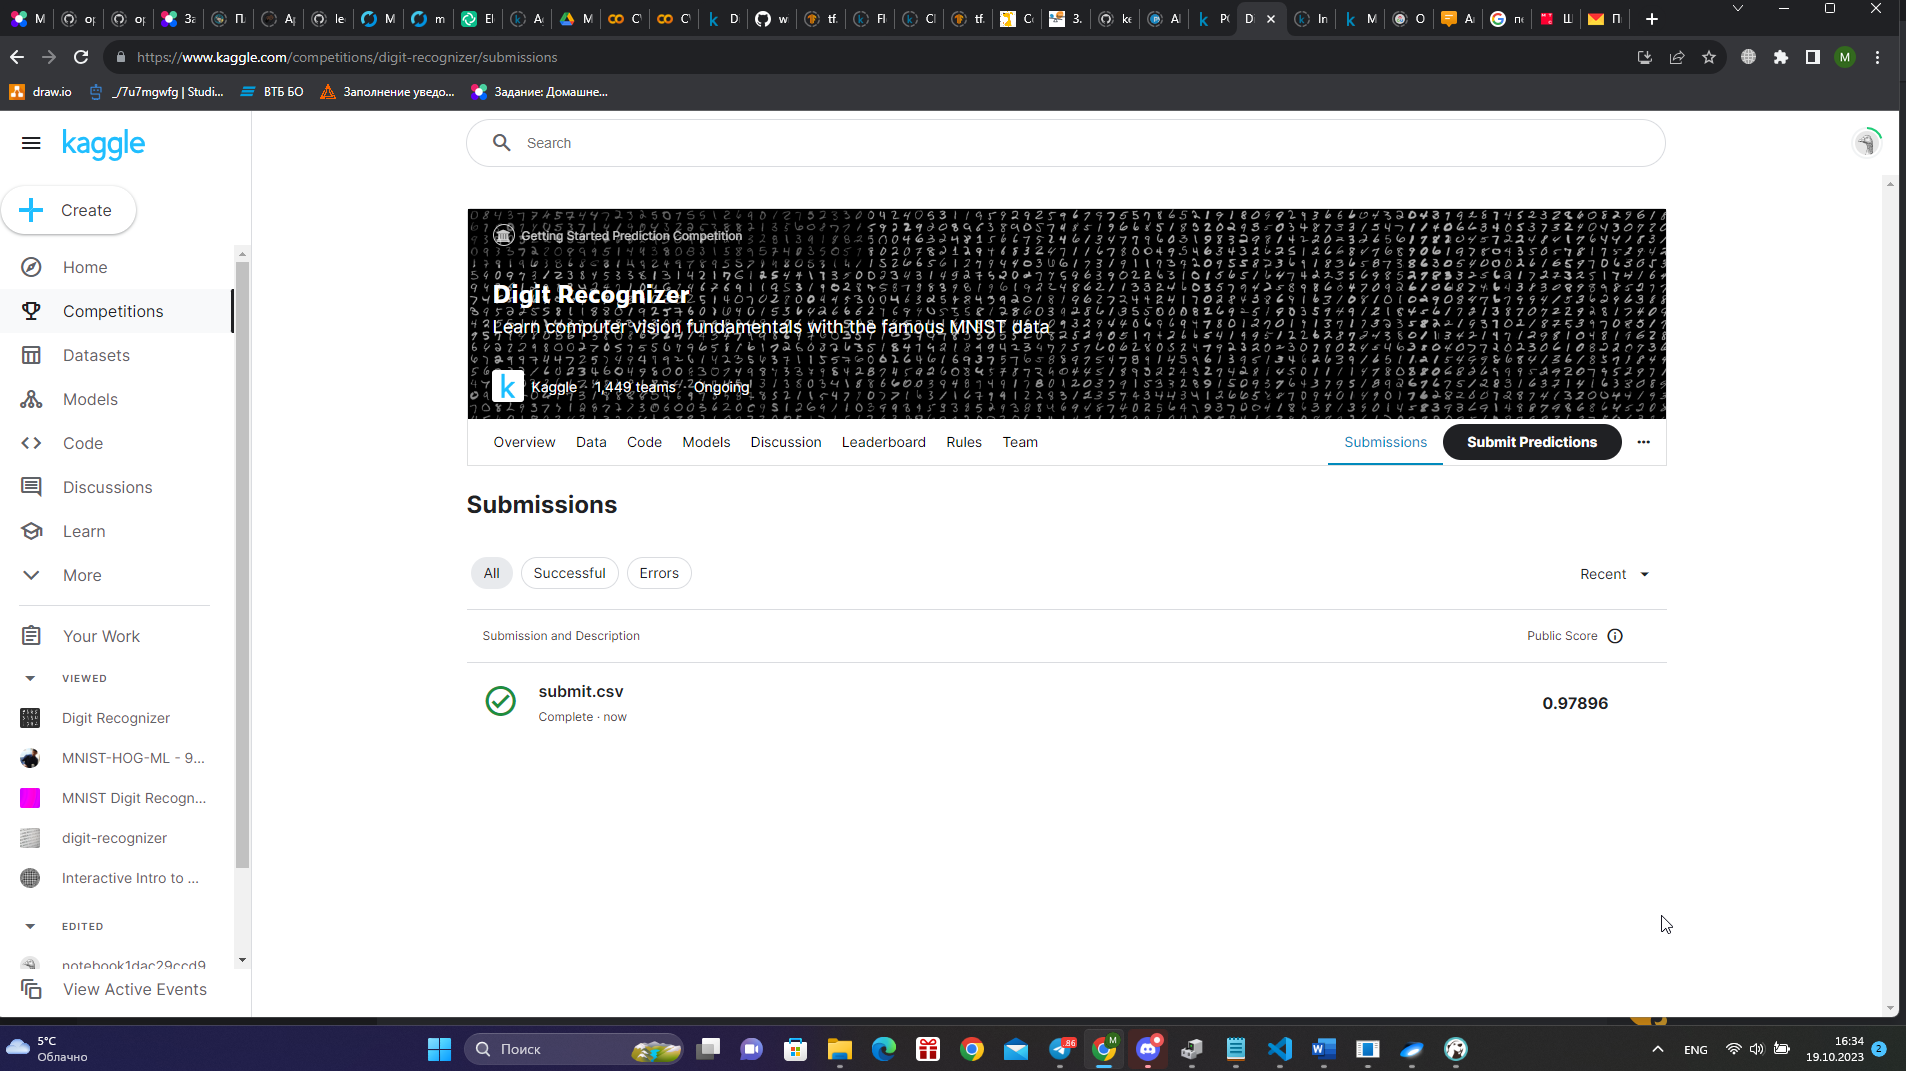